In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!pip install pandas numpy matplotlib seaborn plotly -q


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [ ]:
# Load all datasets
flight_df = pd.read_csv('/content/drive/MyDrive/Skyhack/Flight Level Data.csv')
bag_df = pd.read_csv('/content/drive/MyDrive/Skyhack/Bag+Level+Data.csv')
pnr_flight_df = pd.read_csv('/content/drive/MyDrive/Skyhack/PNR+Flight+Level+Data.csv')
pnr_remarks_df = pd.read_csv('/content/drive/MyDrive/Skyhack/PNR Remark Level Data.csv')
airports_df = pd.read_csv('/content/drive/MyDrive/Skyhack/Airports Data.csv')

print("✅ All files loaded!")
print(f"Flights: {len(flight_df)} rows")
print(f"Bags: {len(bag_df)} rows")
print(f"PNR Flight: {len(pnr_flight_df)} rows")
print(f"PNR Remarks: {len(pnr_remarks_df)} rows")
print(f"Airports: {len(airports_df)} rows")

✅ All files loaded!
Flights: 8099 rows
Bags: 687245 rows
PNR Flight: 687878 rows
PNR Remarks: 51698 rows
Airports: 5612 rows


In [ ]:

print("=== FLIGHT DATA PREVIEW ===")
print(flight_df.head(3))
print("\n=== COLUMN NAMES ===")
print(flight_df.columns.tolist())

=== FLIGHT DATA PREVIEW ===
  company_id  flight_number scheduled_departure_date_local  \
0         OO           4792                     2025-08-04   
1         UA            920                     2025-08-03   
2         UA           1776                     2025-08-10   

  scheduled_departure_station_code scheduled_arrival_station_code  \
0                              ORD                            ROA   
1                              ORD                            LHR   
2                              ORD                            PHL   

  scheduled_departure_datetime_local scheduled_arrival_datetime_local  \
0               2025-08-04T17:57:00Z             2025-08-04T21:04:00Z   
1               2025-08-03T18:05:00Z             2025-08-04T08:20:00Z   
2               2025-08-10T18:20:00Z             2025-08-10T21:35:00Z   

  actual_departure_datetime_local actual_arrival_datetime_local  total_seats  \
0            2025-08-04T18:04:00Z          2025-08-04T20:52:00Z          

In [ ]:
# ========================================
# EDA Q1: Average Delay & Late Departures
# ========================================


flight_df['scheduled_departure_datetime_local'] = pd.to_datetime(flight_df['scheduled_departure_datetime_local'])
flight_df['actual_departure_datetime_local'] = pd.to_datetime(flight_df['actual_departure_datetime_local'])

# Calculate delay in minutes
flight_df['delay_minutes'] = (
    flight_df['actual_departure_datetime_local'] -
    flight_df['scheduled_departure_datetime_local']
).dt.total_seconds() / 60


flight_df_with_delay = flight_df[flight_df['delay_minutes'].notna()].copy()

# Calculate metrics
average_delay = flight_df_with_delay['delay_minutes'].mean()
median_delay = flight_df_with_delay['delay_minutes'].median()
late_flights = (flight_df_with_delay['delay_minutes'] > 0).sum()
total_flights = len(flight_df_with_delay)
percent_late = (late_flights / total_flights) * 100

print("=" * 50)
print("📊 EDA QUESTION 1: DELAY ANALYSIS")
print("=" * 50)
print(f"Average Delay: {average_delay:.2f} minutes")
print(f"Median Delay: {median_delay:.2f} minutes")
print(f"Flights Departed Late: {late_flights} out of {total_flights}")
print(f"Percentage Late: {percent_late:.2f}%")
print(f"Max Delay: {flight_df_with_delay['delay_minutes'].max():.2f} minutes")
print(f"Max Early: {flight_df_with_delay['delay_minutes'].min():.2f} minutes")
print("=" * 50)


eda_findings = {
    'avg_delay': average_delay,
    'percent_late': percent_late,
    'total_flights': total_flights
}

📊 EDA QUESTION 1: DELAY ANALYSIS
Average Delay: 21.18 minutes
Median Delay: 0.00 minutes
Flights Departed Late: 4018 out of 8099
Percentage Late: 49.61%
Max Delay: 1017.00 minutes
Max Early: -17.00 minutes


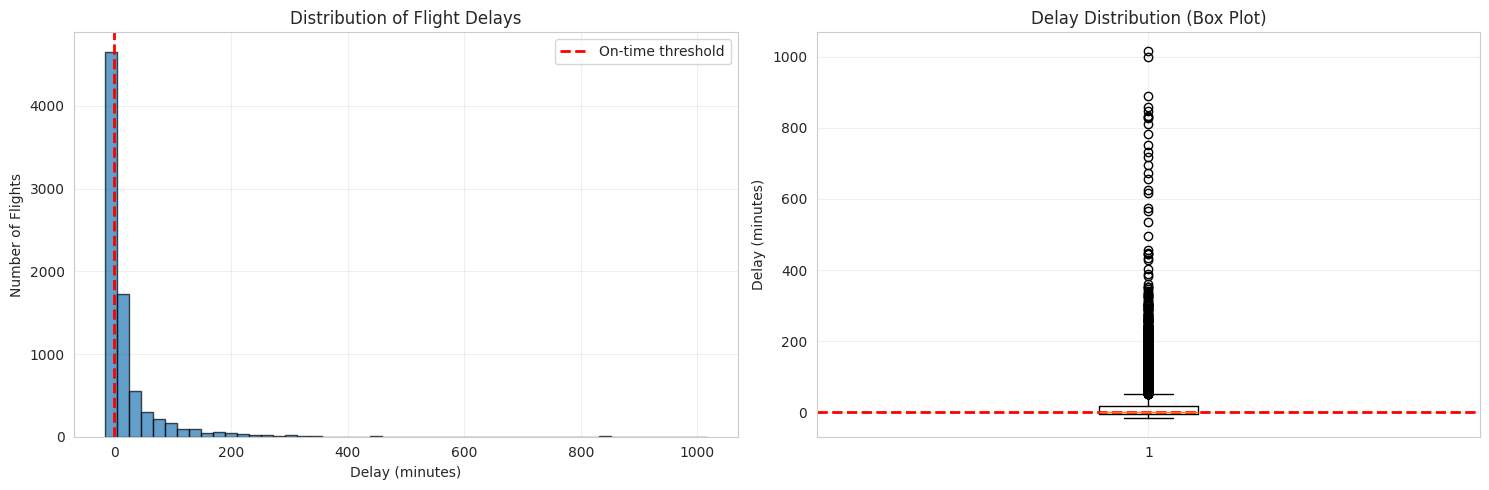

✅ Visualization saved as 'eda_q1_delays.png'


In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(15, 5))


axes[0].hist(flight_df_with_delay['delay_minutes'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='On-time threshold')
axes[0].set_xlabel('Delay (minutes)')
axes[0].set_ylabel('Number of Flights')
axes[0].set_title('Distribution of Flight Delays')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


axes[1].boxplot(flight_df_with_delay['delay_minutes'])
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_ylabel('Delay (minutes)')
axes[1].set_title('Delay Distribution (Box Plot)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eda_q1_delays.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved as 'eda_q1_delays.png'")

In [ ]:
# ========================================
# EDA Q2: Ground Time Constraints
# ========================================


flight_df_ground = flight_df[
    (flight_df['scheduled_ground_time_minutes'].notna()) &
    (flight_df['minimum_turn_minutes'].notna())
].copy()

# Calculate ground time ratio
flight_df_ground['ground_time_ratio'] = (
    flight_df_ground['scheduled_ground_time_minutes'] /
    flight_df_ground['minimum_turn_minutes']
)

# Calculate ground time pressure (lower ratio = higher pressure)
flight_df_ground['ground_time_pressure'] = flight_df_ground['ground_time_ratio'].apply(
    lambda x: 100 if x < 1.0 else (80 if x < 1.1 else (60 if x < 1.2 else max(0, 50 - (x - 1.2) * 10)))
)

# Count flights by ground time category
at_minimum = (flight_df_ground['ground_time_ratio'] <= 1.0).sum()
near_minimum = ((flight_df_ground['ground_time_ratio'] > 1.0) &
                (flight_df_ground['ground_time_ratio'] <= 1.2)).sum()
comfortable = (flight_df_ground['ground_time_ratio'] > 1.2).sum()

total_ground = len(flight_df_ground)
percent_at_min = (at_minimum / total_ground) * 100
percent_near_min = (near_minimum / total_ground) * 100

print("=" * 50)
print("📊 EDA QUESTION 2: GROUND TIME ANALYSIS")
print("=" * 50)
print(f"Average Ground Time: {flight_df_ground['scheduled_ground_time_minutes'].mean():.2f} minutes")
print(f"Average Minimum Turn: {flight_df_ground['minimum_turn_minutes'].mean():.2f} minutes")
print(f"Average Ground Time Ratio: {flight_df_ground['ground_time_ratio'].mean():.2f}")
print(f"\nFlights AT minimum (≤1.0x): {at_minimum} ({percent_at_min:.2f}%)")
print(f"Flights NEAR minimum (1.0-1.2x): {near_minimum} ({percent_near_min:.2f}%)")
print(f"Flights with COMFORTABLE time (>1.2x): {comfortable} ({(comfortable/total_ground)*100:.2f}%)")
print(f"\n⚠️ HIGH RISK flights (≤1.2x): {at_minimum + near_minimum} ({(at_minimum + near_minimum)/total_ground*100:.2f}%)")
print("=" * 50)


eda_findings['percent_tight_ground'] = percent_at_min + percent_near_min
eda_findings['avg_ground_ratio'] = flight_df_ground['ground_time_ratio'].mean()

📊 EDA QUESTION 2: GROUND TIME ANALYSIS
Average Ground Time: 183.79 minutes
Average Minimum Turn: 48.04 minutes
Average Ground Time Ratio: 3.96

Flights AT minimum (≤1.0x): 652 (8.05%)
Flights NEAR minimum (1.0-1.2x): 660 (8.15%)
Flights with COMFORTABLE time (>1.2x): 6787 (83.80%)

⚠️ HIGH RISK flights (≤1.2x): 1312 (16.20%)


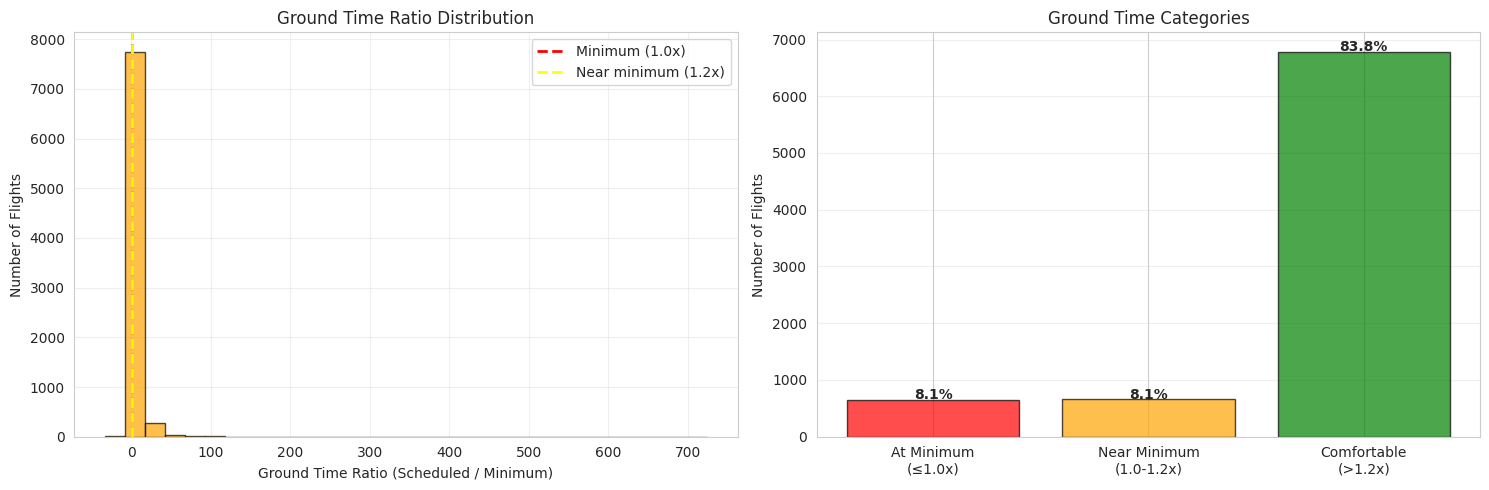

✅ Visualization saved as 'eda_q2_ground_time.png'


In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Ground time ratio distribution
axes[0].hist(flight_df_ground['ground_time_ratio'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0].axvline(1.0, color='red', linestyle='--', linewidth=2, label='Minimum (1.0x)')
axes[0].axvline(1.2, color='yellow', linestyle='--', linewidth=2, label='Near minimum (1.2x)')
axes[0].set_xlabel('Ground Time Ratio (Scheduled / Minimum)')
axes[0].set_ylabel('Number of Flights')
axes[0].set_title('Ground Time Ratio Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Category breakdown
categories = ['At Minimum\n(≤1.0x)', 'Near Minimum\n(1.0-1.2x)', 'Comfortable\n(>1.2x)']
counts = [at_minimum, near_minimum, comfortable]
colors = ['red', 'orange', 'green']

axes[1].bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Number of Flights')
axes[1].set_title('Ground Time Categories')
axes[1].grid(True, alpha=0.3, axis='y')

# Add percentages on bars
for i, (cat, count) in enumerate(zip(categories, counts)):
    pct = (count / total_ground) * 100
    axes[1].text(i, count + 5, f'{pct:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('eda_q2_ground_time.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved as 'eda_q2_ground_time.png'")

In [ ]:
# ========================================
# EDA Q3: Transfer vs Checked Bags
# ========================================

# Aggregate bags by flight
bag_summary = bag_df.groupby(['flight_number', 'scheduled_departure_date_local']).agg({
    'bag_tag_unique_number': 'count',  # Total bags
    'bag_type': lambda x: (x == 'Transfer').sum()  # Transfer bags
}).reset_index()

bag_summary.columns = ['flight_number', 'scheduled_departure_date_local', 'total_bags', 'transfer_bags']

# Calculate checked bags and ratios
bag_summary['checked_bags'] = bag_summary['total_bags'] - bag_summary['transfer_bags']
bag_summary['transfer_ratio'] = bag_summary['transfer_bags'] / bag_summary['total_bags']
bag_summary['transfer_ratio'] = bag_summary['transfer_ratio'].fillna(0)

# Calculate metrics
avg_total_bags = bag_summary['total_bags'].mean()
avg_transfer_bags = bag_summary['transfer_bags'].mean()
avg_checked_bags = bag_summary['checked_bags'].mean()
avg_transfer_ratio = bag_summary['transfer_ratio'].mean()

# High transfer flights (>50% transfer)
high_transfer = (bag_summary['transfer_ratio'] > 0.5).sum()
percent_high_transfer = (high_transfer / len(bag_summary)) * 100

print("=" * 50)
print("📊 EDA QUESTION 3: BAG ANALYSIS")
print("=" * 50)
print(f"Average Total Bags per Flight: {avg_total_bags:.2f}")
print(f"Average Checked Bags: {avg_checked_bags:.2f}")
print(f"Average Transfer Bags: {avg_transfer_bags:.2f}")
print(f"Average Transfer Ratio: {avg_transfer_ratio:.2%}")
print(f"\nFlights with >50% Transfer Bags: {high_transfer} ({percent_high_transfer:.2f}%)")
print(f"Max Bags on Single Flight: {bag_summary['total_bags'].max()}")
print(f"Max Transfer Bags: {bag_summary['transfer_bags'].max()}")
print("=" * 50)


eda_findings['avg_total_bags'] = avg_total_bags
eda_findings['avg_transfer_ratio'] = avg_transfer_ratio

📊 EDA QUESTION 3: BAG ANALYSIS
Average Total Bags per Flight: 67.70
Average Checked Bags: 33.46
Average Transfer Bags: 34.24
Average Transfer Ratio: 58.79%

Flights with >50% Transfer Bags: 5994 (59.05%)
Max Bags on Single Flight: 486
Max Transfer Bags: 366


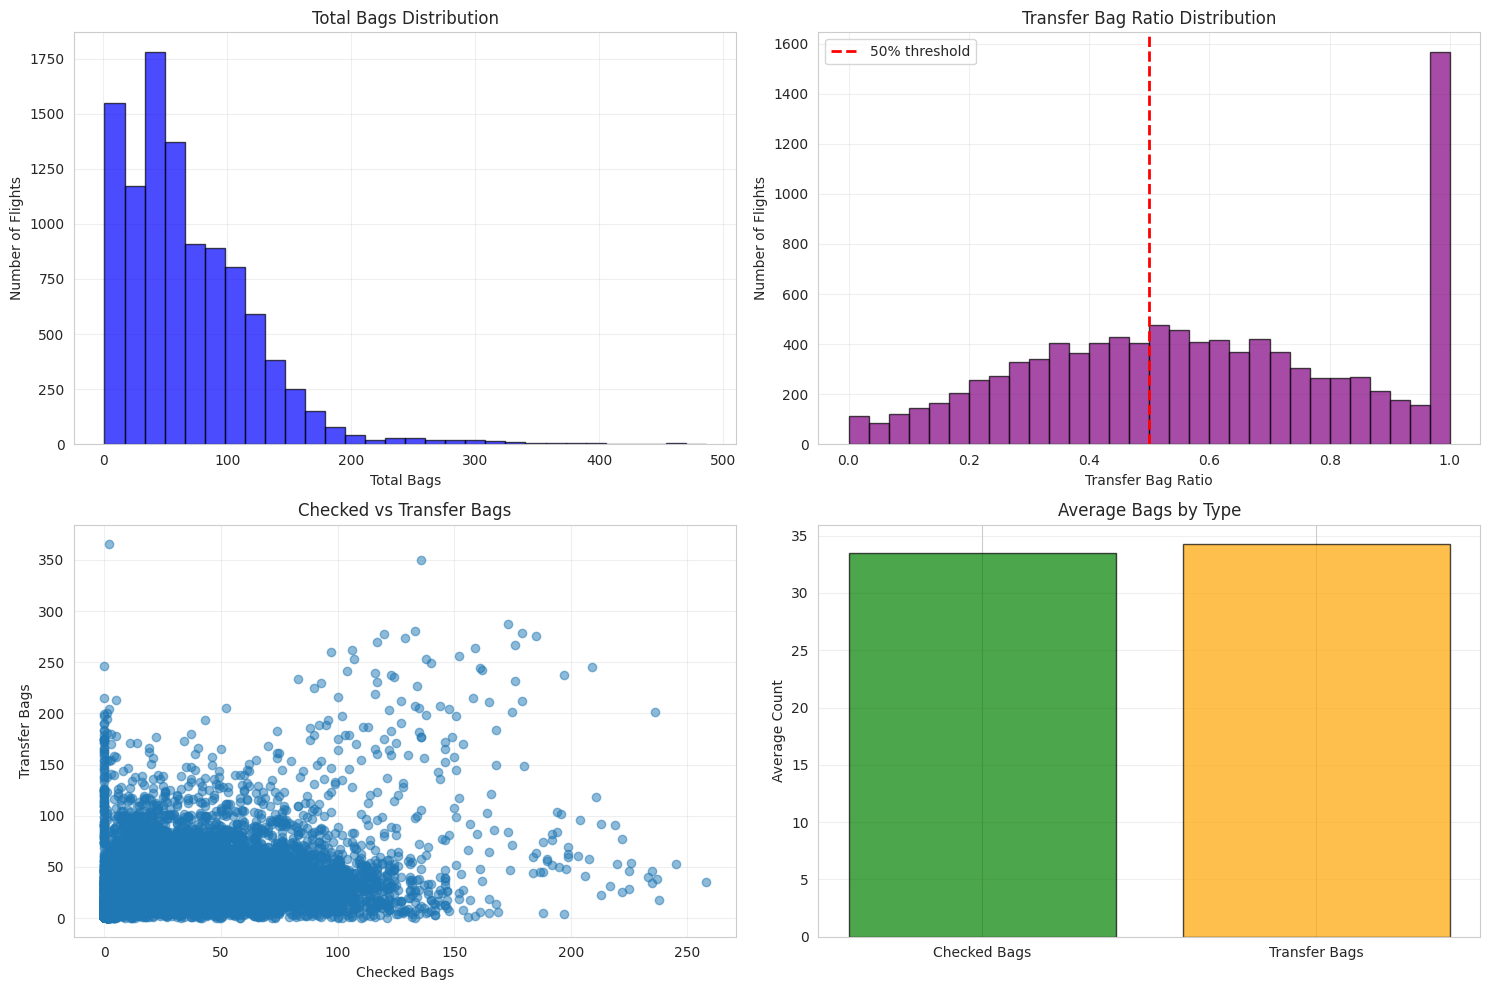

✅ Visualization saved as 'eda_q3_bags.png'


In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total bags distribution
axes[0, 0].hist(bag_summary['total_bags'], bins=30, edgecolor='black', alpha=0.7, color='blue')
axes[0, 0].set_xlabel('Total Bags')
axes[0, 0].set_ylabel('Number of Flights')
axes[0, 0].set_title('Total Bags Distribution')
axes[0, 0].grid(True, alpha=0.3)

# Transfer ratio distribution
axes[0, 1].hist(bag_summary['transfer_ratio'], bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[0, 1].axvline(0.5, color='red', linestyle='--', linewidth=2, label='50% threshold')
axes[0, 1].set_xlabel('Transfer Bag Ratio')
axes[0, 1].set_ylabel('Number of Flights')
axes[0, 1].set_title('Transfer Bag Ratio Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Checked vs Transfer scatter
axes[1, 0].scatter(bag_summary['checked_bags'], bag_summary['transfer_bags'], alpha=0.5)
axes[1, 0].set_xlabel('Checked Bags')
axes[1, 0].set_ylabel('Transfer Bags')
axes[1, 0].set_title('Checked vs Transfer Bags')
axes[1, 0].grid(True, alpha=0.3)

# Bag type comparison
bag_types = ['Checked Bags', 'Transfer Bags']
avg_values = [avg_checked_bags, avg_transfer_bags]
axes[1, 1].bar(bag_types, avg_values, color=['green', 'orange'], alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('Average Count')
axes[1, 1].set_title('Average Bags by Type')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('eda_q3_bags.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved as 'eda_q3_bags.png'")

In [ ]:
# ========================================
# EDA Q4: Passenger Load Analysis
# ========================================

# Aggregate passengers by flight
pnr_summary = pnr_flight_df.groupby(['flight_number', 'scheduled_departure_date_local']).agg({
    'total_pax': 'sum',
    'lap_child_count': 'sum',
    'is_child': lambda x: (x == 'Y').sum(), # Convert 'Y'/'N' to 1/0 and sum
    'basic_economy_ind': 'sum',
    'is_stroller_user': lambda x: (x == 'Y').sum() # Convert 'Y'/'N' to 1/0 and sum
}).reset_index()

# Merge with flight data to get total_seats
passenger_load = flight_df[['flight_number', 'scheduled_departure_date_local', 'total_seats', 'delay_minutes']].merge(
    pnr_summary,
    on=['flight_number', 'scheduled_departure_date_local'],
    how='left'
)

# Fill nulls with 0
passenger_load[['total_pax', 'lap_child_count', 'is_child', 'basic_economy_ind', 'is_stroller_user']] = \
    passenger_load[['total_pax', 'lap_child_count', 'is_child', 'basic_economy_ind', 'is_stroller_user']].fillna(0)

# Calculate load factor
passenger_load['load_factor'] = passenger_load['total_pax'] / passenger_load['total_seats']
passenger_load['load_factor'] = passenger_load['load_factor'].clip(upper=1.0)  # Cap at 100%

# Calculate metrics
avg_passengers = passenger_load['total_pax'].mean()
avg_load_factor = passenger_load['load_factor'].mean()
avg_children = passenger_load['is_child'].mean()
avg_lap_children = passenger_load['lap_child_count'].mean()
avg_strollers = passenger_load['is_stroller_user'].mean()

# High load flights (>90%)
high_load = (passenger_load['load_factor'] > 0.9).sum()
percent_high_load = (high_load / len(passenger_load)) * 100

print("=" * 50)
print("📊 EDA QUESTION 4: PASSENGER LOAD ANALYSIS")
print("=" * 50)
print(f"Average Passengers per Flight: {avg_passengers:.2f}")
print(f"Average Load Factor: {avg_load_factor:.2%}")
print(f"Average Children per Flight: {avg_children:.2f}")
print(f"Average Lap Children: {avg_lap_children:.2f}")
print(f"Average Stroller Users: {avg_strollers:.2f}")
print(f"\nFlights with >90% Load: {high_load} ({percent_high_load:.2f}%)")
print(f"Max Passengers on Single Flight: {passenger_load['total_pax'].max():.0f}")
print("=" * 50)

# Correlation with delay
passenger_load_corr = passenger_load[passenger_load['delay_minutes'].notna()]
correlation = passenger_load_corr[['load_factor', 'delay_minutes']].corr().iloc[0, 1]
print(f"\n📈 Correlation between Load Factor and Delay: {correlation:.3f}")

# Update findings
eda_findings['avg_load_factor'] = avg_load_factor
eda_findings['load_delay_correlation'] = correlation

📊 EDA QUESTION 4: PASSENGER LOAD ANALYSIS
Average Passengers per Flight: 128.48
Average Load Factor: 93.45%
Average Children per Flight: 5.18
Average Lap Children: 0.69
Average Stroller Users: 1.09

Flights with >90% Load: 6437 (79.48%)
Max Passengers on Single Flight: 530

📈 Correlation between Load Factor and Delay: -0.166


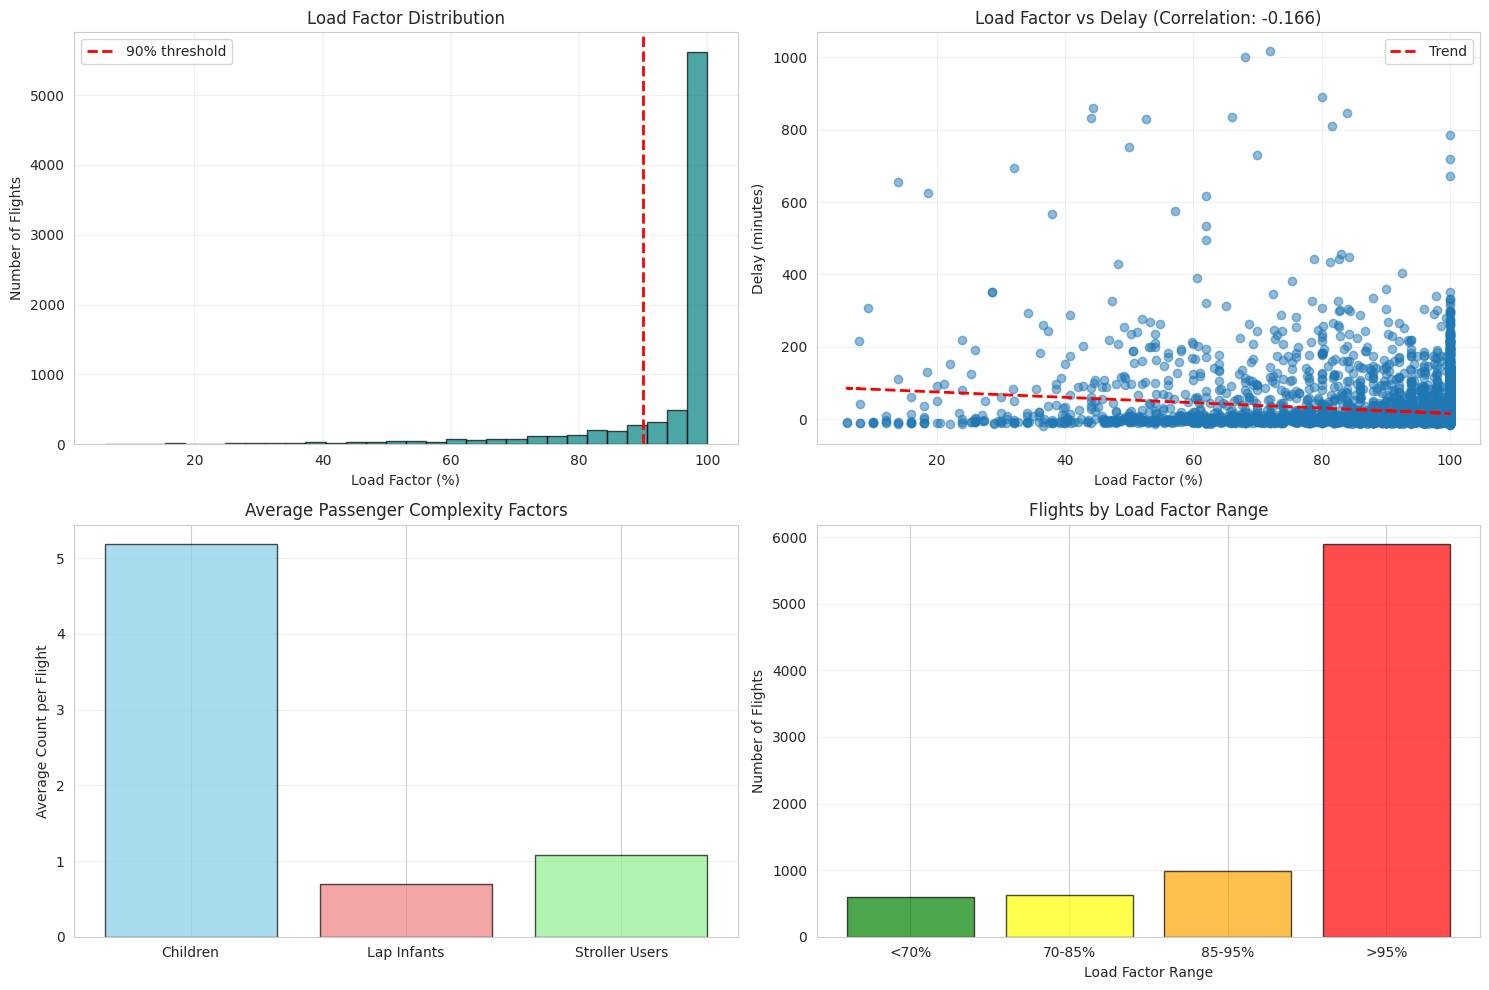

✅ Visualization saved as 'eda_q4_passengers.png'


In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Load factor distribution
axes[0, 0].hist(passenger_load['load_factor'] * 100, bins=30, edgecolor='black', alpha=0.7, color='teal')
axes[0, 0].axvline(90, color='red', linestyle='--', linewidth=2, label='90% threshold')
axes[0, 0].set_xlabel('Load Factor (%)')
axes[0, 0].set_ylabel('Number of Flights')
axes[0, 0].set_title('Load Factor Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Load factor vs delay scatter
valid_data = passenger_load[passenger_load['delay_minutes'].notna()]
axes[0, 1].scatter(valid_data['load_factor'] * 100, valid_data['delay_minutes'], alpha=0.5)
axes[0, 1].set_xlabel('Load Factor (%)')
axes[0, 1].set_ylabel('Delay (minutes)')
axes[0, 1].set_title(f'Load Factor vs Delay (Correlation: {correlation:.3f})')
axes[0, 1].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(valid_data['load_factor'].dropna(), valid_data['delay_minutes'].dropna(), 1)
p = np.poly1d(z)
axes[0, 1].plot(valid_data['load_factor'] * 100, p(valid_data['load_factor']), "r--", linewidth=2, label='Trend')
axes[0, 1].legend()

# Passenger complexity factors
factors = ['Children', 'Lap Infants', 'Stroller Users']
avg_counts = [avg_children, avg_lap_children, avg_strollers]
axes[1, 0].bar(factors, avg_counts, color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Average Count per Flight')
axes[1, 0].set_title('Average Passenger Complexity Factors')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Load factor bins
bins = [0, 0.7, 0.85, 0.95, 1.0]
labels = ['<70%', '70-85%', '85-95%', '>95%']
passenger_load['load_bin'] = pd.cut(passenger_load['load_factor'], bins=bins, labels=labels)
load_counts = passenger_load['load_bin'].value_counts().sort_index()

axes[1, 1].bar(load_counts.index.astype(str), load_counts.values,
               color=['green', 'yellow', 'orange', 'red'], alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Load Factor Range')
axes[1, 1].set_ylabel('Number of Flights')
axes[1, 1].set_title('Flights by Load Factor Range')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('eda_q4_passengers.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved as 'eda_q4_passengers.png'")

In [ ]:
# ========================================
# EDA Q5: Special Services vs Delay
# ========================================

# Count special service requests by flight
special_services = pnr_remarks_df.groupby(['flight_number', 'pnr_creation_date']).agg({
    'special_service_request': 'count'
}).reset_index()
special_services.columns = ['flight_number', 'pnr_creation_date', 'special_service_count']

# Merge with passenger load and delay data
services_analysis = passenger_load[['flight_number', 'scheduled_departure_date_local', # Use scheduled_departure_date_local
                                     'delay_minutes', 'load_factor', 'total_pax']].merge(
    special_services,
    left_on=['flight_number', 'scheduled_departure_date_local'], # Merge on flight date
    right_on=['flight_number', 'pnr_creation_date'], # Merge on pnr creation date
    how='left'
)
services_analysis['special_service_count'] = services_analysis['special_service_count'].fillna(0)

# Remove flights without delay data
services_analysis = services_analysis[services_analysis['delay_minutes'].notna()]

# Categorize flights
services_analysis['high_service'] = services_analysis['special_service_count'] >= \
    services_analysis['special_service_count'].quantile(0.75)
services_analysis['high_load'] = services_analysis['load_factor'] >= 0.85

# Calculate average delays by category
avg_delay_high_service = services_analysis[services_analysis['high_service']]['delay_minutes'].mean()
avg_delay_low_service = services_analysis[~services_analysis['high_service']]['delay_minutes'].mean()

# Control for load factor
high_service_high_load = services_analysis[
    (services_analysis['high_service']) & (services_analysis['high_load'])
]['delay_minutes'].mean()

high_service_low_load = services_analysis[
    (services_analysis['high_service']) & (~services_analysis['high_load'])
]['delay_minutes'].mean()

low_service_high_load = services_analysis[
    (~services_analysis['high_service']) & (services_analysis['high_load'])
]['delay_minutes'].mean()

low_service_low_load = services_analysis[
    (~services_analysis['high_service']) & (~services_analysis['high_load'])
]['delay_minutes'].mean()

# Correlation
service_delay_corr = services_analysis[['special_service_count', 'delay_minutes']].corr().iloc[0, 1]

print("=" * 50)
print("📊 EDA QUESTION 5: SPECIAL SERVICES & DELAY")
print("=" * 50)
print(f"Average Special Service Requests per Flight: {services_analysis['special_service_count'].mean():.2f}")
print(f"Max Special Services on Single Flight: {services_analysis['special_service_count'].max():.0f}")
print(f"\n--- Without Controlling for Load ---")
print(f"Avg Delay (High Special Services): {avg_delay_high_service:.2f} min")
print(f"Avg Delay (Low Special Services): {avg_delay_low_service:.2f} min")
print(f"Difference: {avg_delay_high_service - avg_delay_low_service:.2f} min")
print(f"\n--- Controlling for Load Factor ---")
print(f"High Service + High Load: {high_service_high_load:.2f} min delay")
print(f"High Service + Low Load: {high_service_low_load:.2f} min delay")
print(f"Low Service + High Load: {low_service_high_load:.2f} min delay")
print(f"Low Service + Low Load: {low_service_low_load:.2f} min delay")
print(f"\n📈 Correlation (Special Services & Delay): {service_delay_corr:.3f}")
print("=" * 50)

# Update findings
eda_findings['service_delay_correlation'] = service_delay_corr

📊 EDA QUESTION 5: SPECIAL SERVICES & DELAY
Average Special Service Requests per Flight: 0.45
Max Special Services on Single Flight: 9

--- Without Controlling for Load ---
Avg Delay (High Special Services): 20.94 min
Avg Delay (Low Special Services): 21.29 min
Difference: -0.35 min

--- Controlling for Load Factor ---
High Service + High Load: 17.14 min delay
High Service + Low Load: 47.35 min delay
Low Service + High Load: 16.54 min delay
Low Service + Low Load: 45.75 min delay

📈 Correlation (Special Services & Delay): -0.001


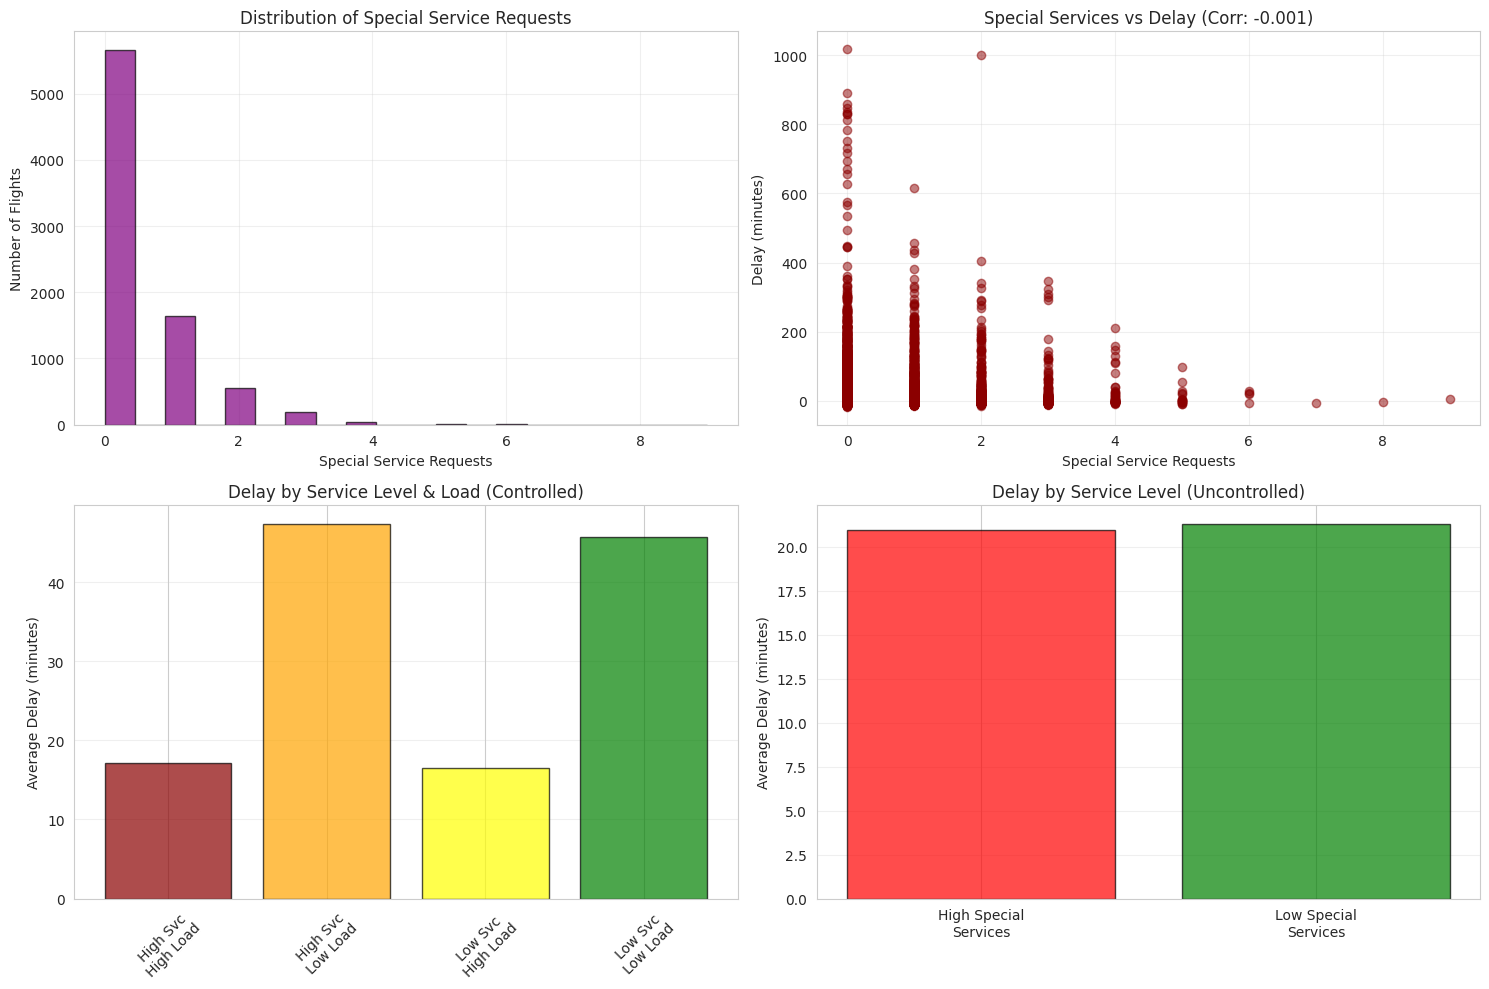

✅ Visualization saved as 'eda_q5_special_services.png'


In [ ]:
# Visualize special services
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Special service distribution
axes[0, 0].hist(services_analysis['special_service_count'], bins=20, edgecolor='black', alpha=0.7, color='purple')
axes[0, 0].set_xlabel('Special Service Requests')
axes[0, 0].set_ylabel('Number of Flights')
axes[0, 0].set_title('Distribution of Special Service Requests')
axes[0, 0].grid(True, alpha=0.3)

# Special services vs delay
axes[0, 1].scatter(services_analysis['special_service_count'],
                   services_analysis['delay_minutes'], alpha=0.5, color='darkred')
axes[0, 1].set_xlabel('Special Service Requests')
axes[0, 1].set_ylabel('Delay (minutes)')
axes[0, 1].set_title(f'Special Services vs Delay (Corr: {service_delay_corr:.3f})')
axes[0, 1].grid(True, alpha=0.3)

# Comparison with/without load control
categories = ['High Svc\nHigh Load', 'High Svc\nLow Load', 'Low Svc\nHigh Load', 'Low Svc\nLow Load']
delays = [high_service_high_load, high_service_low_load, low_service_high_load, low_service_low_load]
colors_bar = ['darkred', 'orange', 'yellow', 'green']

axes[1, 0].bar(categories, delays, color=colors_bar, alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Average Delay (minutes)')
axes[1, 0].set_title('Delay by Service Level & Load (Controlled)')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].tick_params(axis='x', rotation=45)

# Simple comparison
simple_categories = ['High Special\nServices', 'Low Special\nServices']
simple_delays = [avg_delay_high_service, avg_delay_low_service]
axes[1, 1].bar(simple_categories, simple_delays, color=['red', 'green'], alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('Average Delay (minutes)')
axes[1, 1].set_title('Delay by Service Level (Uncontrolled)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('eda_q5_special_services.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved as 'eda_q5_special_services.png'")

In [ ]:
# ========================================
# SUMMARY REPORT
# ========================================

print("\n" + "=" * 60)
print("🎯 EDA SUMMARY - KEY FINDINGS FOR DIFFICULTY SCORE")
print("=" * 60)

print("\n1️⃣ DELAY PATTERNS:")
print(f"   • Average delay: {eda_findings['avg_delay']:.2f} minutes")
print(f"   • {eda_findings['percent_late']:.1f}% of flights depart late")
print(f"   • Total flights analyzed: {eda_findings['total_flights']}")

print("\n2️⃣ GROUND TIME CONSTRAINTS:")
print(f"   • {eda_findings['percent_tight_ground']:.1f}% have tight ground time (≤1.2x minimum)")
print(f"   • Average ground time ratio: {eda_findings['avg_ground_ratio']:.2f}x")
print(f"   • ⚠️ This is a MAJOR difficulty driver!")

print("\n3️⃣ BAGGAGE COMPLEXITY:")
print(f"   • Average {eda_findings['avg_total_bags']:.1f} bags per flight")
print(f"   • {eda_findings['avg_transfer_ratio']:.1%} are transfer bags (need quick handling)")
print(f"   • Transfer bags = time pressure!")

print("\n4️⃣ PASSENGER LOAD:")
print(f"   • Average load factor: {eda_findings['avg_load_factor']:.1%}")
print(f"   • Load-delay correlation: {eda_findings['load_delay_correlation']:.3f}")
print(f"   • Fuller flights = more complexity")

print("\n5️⃣ SPECIAL SERVICES:")
print(f"   • Service-delay correlation: {eda_findings['service_delay_correlation']:.3f}")
print(f"   • Even after controlling for load, high services = higher delays")

print("\n" + "=" * 60)
print("💡 RECOMMENDED DIFFICULTY SCORE PARAMETERS:")
print("=" * 60)
print("""
Based on EDA, here are the KEY features for your difficulty score:

1. Ground Time Pressure (WEIGHT: 30-35%)
   - Formula: If ratio < 1.0 → score 100
             If ratio < 1.2 → score 80
             Else → decreasing score

2. Transfer Bags (WEIGHT: 20-25%)
   - More transfer bags = higher difficulty
   - Consider: transfer_bags / ground_time (velocity!)

3. Total Bags (WEIGHT: 10-15%)
   - Raw volume matters

4. Load Factor (WEIGHT: 10-15%)
   - Higher load = more boarding time

5. Special Services (WEIGHT: 15-20%)
   - Each wheelchair, child, stroller adds time

6. Delay History (WEIGHT: 5-10%)
   - Flights already delayed compound issues

FORMULA SUGGESTION:
difficulty_score = (
    35 × ground_time_pressure_score +
    25 × transfer_bag_score +
    15 × total_bag_score +
    10 × load_factor_score +
    15 × special_service_score
)
""")

print("=" * 60)


🎯 EDA SUMMARY - KEY FINDINGS FOR DIFFICULTY SCORE

1️⃣ DELAY PATTERNS:
   • Average delay: 21.18 minutes
   • 49.6% of flights depart late
   • Total flights analyzed: 8099

2️⃣ GROUND TIME CONSTRAINTS:
   • 16.2% have tight ground time (≤1.2x minimum)
   • Average ground time ratio: 3.96x
   • ⚠️ This is a MAJOR difficulty driver!

3️⃣ BAGGAGE COMPLEXITY:
   • Average 67.7 bags per flight
   • 58.8% are transfer bags (need quick handling)
   • Transfer bags = time pressure!

4️⃣ PASSENGER LOAD:
   • Average load factor: 93.5%
   • Load-delay correlation: -0.166
   • Fuller flights = more complexity

5️⃣ SPECIAL SERVICES:
   • Service-delay correlation: -0.001
   • Even after controlling for load, high services = higher delays

💡 RECOMMENDED DIFFICULTY SCORE PARAMETERS:

Based on EDA, here are the KEY features for your difficulty score:

1. Ground Time Pressure (WEIGHT: 30-35%)
   - Formula: If ratio < 1.0 → score 100
             If ratio < 1.2 → score 80
             Else → decreasi

In [ ]:
# Save findings to file for reference
import json

with open('eda_findings.json', 'w') as f:
    json.dump(eda_findings, f, indent=4)

print("\n✅ EDA findings saved to 'eda_findings.json'")
print("✅ All visualizations saved as PNG files")
print("\n🎯 You can now use these insights to build your difficulty score!")


✅ EDA findings saved to 'eda_findings.json'
✅ All visualizations saved as PNG files

🎯 You can now use these insights to build your difficulty score!


Master dataset

In [ ]:
# ========================================
# PART 8: CREATE MASTER DATASET FOR SCORING
# ========================================

print("🔄 Building master dataset for difficulty scoring...")
print("="*60)

# ============================================
# STEP 1: Start with Flight Data (Base)
# ============================================
print("\n1️⃣ Starting with flight data...")
master_df = flight_df.copy()

# Convert datetime
master_df['scheduled_departure_datetime_local'] = pd.to_datetime(
    master_df['scheduled_departure_datetime_local'], errors='coerce'
)

# Include delay_minutes from flight_df
master_df['delay_minutes'] = flight_df['delay_minutes']


print(f"   ✅ Base: {len(master_df)} flights")

# ============================================
# STEP 2: Calculate Ground Time Features
# ============================================
print("\n2️⃣ Calculating ground time features...")

# Ground time ratio
master_df['ground_time_ratio'] = (
    master_df['scheduled_ground_time_minutes'] /
    master_df['minimum_turn_minutes']
)

# Ground time pressure score (0-100)
def calculate_ground_pressure(ratio):
    if pd.isna(ratio):
        return 50  # Neutral if missing
    elif ratio < 1.0:
        return 100  # Impossible timeline!
    elif ratio < 1.1:
        return 90   # Extremely tight
    elif ratio < 1.2:
        return 75   # Very tight
    elif ratio < 1.5:
        return 50   # Moderate
    else:
        return max(0, 50 - (ratio - 1.5) * 5)  # Decreasing difficulty

master_df['ground_time_pressure'] = master_df['ground_time_ratio'].apply(
    calculate_ground_pressure
)

print(f"   ✅ Ground time features added")
print(f"      Average pressure score: {master_df['ground_time_pressure'].mean():.2f}")

# ============================================
# STEP 3: Merge Bag Data (Aggregated)
# ============================================
print("\n3️⃣ Aggregating and merging bag data...")

# You already have bag_summary from Part 4
# If not, create it:
if 'bag_summary' not in globals():
    bag_summary = bag_df.groupby(['flight_number', 'scheduled_departure_date_local']).agg({
        'bag_tag_unique_number': 'count',
        'bag_type': lambda x: (x == 'Transfer').sum()
    }).reset_index()
    bag_summary.columns = ['flight_number', 'scheduled_departure_date_local',
                           'total_bags', 'transfer_bags']
    bag_summary['checked_bags'] = bag_summary['total_bags'] - bag_summary['transfer_bags']
    bag_summary['transfer_ratio'] = bag_summary['transfer_bags'] / bag_summary['total_bags']
    bag_summary['transfer_ratio'] = bag_summary['transfer_ratio'].fillna(0)

master_df = master_df.merge(
    bag_summary[['flight_number', 'scheduled_departure_date_local',
                 'total_bags', 'transfer_bags', 'checked_bags', 'transfer_ratio']],
    on=['flight_number', 'scheduled_departure_date_local'],
    how='left'
)

# Fill nulls with 0 (flights with no bag data)
master_df['total_bags'] = master_df['total_bags'].fillna(0)
master_df['transfer_bags'] = master_df['transfer_bags'].fillna(0)
master_df['checked_bags'] = master_df['checked_bags'].fillna(0)
master_df['transfer_ratio'] = master_df['transfer_ratio'].fillna(0)

print(f"   ✅ Bag data merged")
print(f"      Flights with bag data: {(master_df['total_bags'] > 0).sum()}")

# ============================================
# STEP 4: Merge Passenger Data (Aggregated)
# ============================================
print("\n4️⃣ Aggregating and merging passenger data...")

# You already have pnr_summary from Part 5
# If not, create it:
if 'pnr_summary' not in globals():
    pnr_summary = pnr_flight_df.groupby(['flight_number', 'scheduled_departure_date_local']).agg({
        'total_pax': 'sum',
        'lap_child_count': 'sum',
        'is_child': 'sum',
        'basic_economy_ind': 'sum', # Corrected column name
        'is_stroller_user': 'sum'
    }).reset_index()

master_df = master_df.merge(
    pnr_summary,
    on=['flight_number', 'scheduled_departure_date_local'],
    how='left'
)

# Fill nulls with 0
master_df['total_pax'] = master_df['total_pax'].fillna(0)
master_df['lap_child_count'] = master_df['lap_child_count'].fillna(0)
master_df['is_child'] = master_df['is_child'].fillna(0)
master_df['basic_economy_ind'] = master_df['basic_economy_ind'].fillna(0) # Corrected column name
master_df['is_stroller_user'] = master_df['is_stroller_user'].fillna(0)

# Calculate load factor
master_df['load_factor'] = master_df['total_pax'] / master_df['total_seats']
master_df['load_factor'] = master_df['load_factor'].clip(upper=1.0)  # Cap at 100%
master_df['load_factor'] = master_df['load_factor'].fillna(0)

print(f"   ✅ Passenger data merged")
print(f"      Average load factor: {master_df['load_factor'].mean():.2%}")

# ============================================
# STEP 5: Merge Special Services (Aggregated)
# ============================================
print("\n5️⃣ Aggregating and merging special services...")

# You already have special_services from Part 6
# If not, create it:
if 'special_services' not in globals():
    special_services = pnr_remarks_df.groupby(
        ['flight_number', 'pnr_creation_date'] # Corrected grouping column
    ).agg({
        'special_service_request': 'count'
    }).reset_index()
    special_services.columns = ['flight_number', 'pnr_creation_date', # Corrected column name
                                'special_service_count']

master_df = master_df.merge(
    special_services,
    left_on=['flight_number', 'scheduled_departure_date_local'], # Corrected merge key
    right_on=['flight_number', 'pnr_creation_date'], # Corrected merge key
    how='left'
)

master_df['special_service_count'] = master_df['special_service_count'].fillna(0)

print(f"   ✅ Special services merged")
print(f"      Flights with special services: {(master_df['special_service_count'] > 0).sum()}")

# ============================================
# STEP 6: Add Destination Data
# ============================================
print("\n6️⃣ Adding destination information...")

master_df = master_df.merge(
    airports_df[['airport_iata_code', 'iso_country_code']],
    left_on='scheduled_arrival_station_code',
    right_on='airport_iata_code',
    how='left'
)

# International flag
master_df['is_international'] = (master_df['iso_country_code'] != 'US').astype(int)
master_df['is_international'] = master_df['is_international'].fillna(0)

print(f"   ✅ Destination data added")
print(f"      International flights: {master_df['is_international'].sum()}")

print("\n" + "="*60)
print(f"✅ MASTER DATASET CREATED: {len(master_df)} flights")
print(f"✅ Current features: {len(master_df.columns)}")
print("="*60)

🔄 Building master dataset for difficulty scoring...

1️⃣ Starting with flight data...
   ✅ Base: 8099 flights

2️⃣ Calculating ground time features...
   ✅ Ground time features added
      Average pressure score: 48.65

3️⃣ Aggregating and merging bag data...
   ✅ Bag data merged
      Flights with bag data: 8099

4️⃣ Aggregating and merging passenger data...
   ✅ Passenger data merged
      Average load factor: 93.45%

5️⃣ Aggregating and merging special services...
   ✅ Special services merged
      Flights with special services: 2442

6️⃣ Adding destination information...
   ✅ Destination data added
      International flights: 747

✅ MASTER DATASET CREATED: 8099 flights
✅ Current features: 33


In [ ]:
# ========================================
# PART 9: ADD UNIQUE FEATURES
# ========================================

print("\n🌟 Adding unique features to stand out...")
print("="*60)

# ============================================
# Feature 1: TIME-BASED FEATURES
# ============================================
print("\n1️⃣ Time-based complexity features...")

# Extract time components
master_df['hour_of_day'] = master_df['scheduled_departure_datetime_local'].dt.hour
master_df['day_of_week'] = master_df['scheduled_departure_datetime_local'].dt.dayofweek
master_df['is_weekend'] = master_df['day_of_week'].isin([5, 6]).astype(int)

# Peak hour indicator (morning rush 6-9am, evening rush 5-8pm)
master_df['is_peak_hour'] = master_df['hour_of_day'].apply(
    lambda x: 1 if (6 <= x <= 9) or (17 <= x <= 20) else 0
)

# Early morning complexity (before 6am - crew fatigue, limited staff)
master_df['is_early_morning'] = (master_df['hour_of_day'] < 6).astype(int)

# Late evening (after 10pm - crew at duty limits)
master_df['is_late_evening'] = (master_df['hour_of_day'] >= 22).astype(int)

print(f"   ✅ Peak hour flights: {master_df['is_peak_hour'].sum()}")
print(f"   ✅ Early morning flights: {master_df['is_early_morning'].sum()}")

# ============================================
# Feature 2: BAGGAGE VELOCITY (Critical!)
# ============================================
print("\n2️⃣ Baggage velocity (bags per minute)...")

# Total baggage velocity
master_df['baggage_velocity'] = (
    master_df['total_bags'] /
    master_df['scheduled_ground_time_minutes'].replace(0, np.nan)
)
master_df['baggage_velocity'] = master_df['baggage_velocity'].fillna(0)

# Transfer bag velocity (even more critical!)
master_df['transfer_velocity'] = (
    master_df['transfer_bags'] /
    master_df['scheduled_ground_time_minutes'].replace(0, np.nan)
)
master_df['transfer_velocity'] = master_df['transfer_velocity'].fillna(0)

# Velocity pressure score (0-100)
# Higher velocity = more difficulty
master_df['velocity_pressure'] = master_df['baggage_velocity'].apply(
    lambda x: min(100, x * 10)  # Scale so 10 bags/min = 100
)

print(f"   ✅ Average baggage velocity: {master_df['baggage_velocity'].mean():.2f} bags/min")
print(f"   ✅ Average transfer velocity: {master_df['transfer_velocity'].mean():.2f} bags/min")

# ============================================
# Feature 3: AIRCRAFT SIZE COMPLEXITY
# ============================================
print("\n3️⃣ Aircraft size complexity...")

# Larger aircraft = more passengers, more bags, longer boarding
master_df['aircraft_size_score'] = master_df['total_seats'].apply(
    lambda x: 100 if x > 200 else (70 if x > 150 else (40 if x > 100 else 20))
)

# Wide-body indicator (typically >200 seats)
master_df['is_widebody'] = (master_df['total_seats'] > 200).astype(int)

print(f"   ✅ Wide-body flights: {master_df['is_widebody'].sum()}")

# ============================================
# Feature 4: CHILD/FAMILY COMPLEXITY
# ============================================
print("\n4️⃣ Child and family complexity...")

# Ensure columns are numeric before calculation
master_df['is_child'] = pd.to_numeric(master_df['is_child'], errors='coerce').fillna(0)
master_df['lap_child_count'] = pd.to_numeric(master_df['lap_child_count'], errors='coerce').fillna(0)
master_df['is_stroller_user'] = pd.to_numeric(master_df['is_stroller_user'], errors='coerce').fillna(0)


# Weighted child complexity (different factors have different impact)
master_df['child_complexity'] = (
    master_df['is_child'] * 1.0 +           # Regular children
    master_df['lap_child_count'] * 1.5 +    # Lap infants (more complex)
    master_df['is_stroller_user'] * 2.0     # Strollers (gate check needed)
)

# Child ratio (% of passengers that are children)
master_df['child_ratio'] = (
    master_df['is_child'] /
    master_df['total_pax'].replace(0, np.nan)
)
master_df['child_ratio'] = master_df['child_ratio'].fillna(0)

print(f"   ✅ Average child complexity: {master_df['child_complexity'].mean():.2f}")

# ============================================
# Feature 5: SERVICE INTENSITY
# ============================================
print("\n5️⃣ Service intensity (per passenger)...")

# Services per passenger
master_df['service_intensity'] = (
    master_df['special_service_count'] /
    master_df['total_pax'].replace(0, np.nan)
)
master_df['service_intensity'] = master_df['service_intensity'].fillna(0)

print(f"   ✅ Average service intensity: {master_df['service_intensity'].mean():.4f}")

# ============================================
# Feature 6: PASSENGER DENSITY
# ============================================
print("\n6️⃣ Passenger density metrics...")

# Bags per passenger (more bags = more handling time per person)
master_df['bags_per_pax'] = (
    master_df['total_bags'] /
    master_df['total_pax'].replace(0, np.nan)
)
master_df['bags_per_pax'] = master_df['bags_per_pax'].fillna(0)

# Basic economy ratio (might board slower, more carry-ons)
master_df['basic_economy_ratio'] = (
    master_df['basic_economy_ind'] / # Corrected column name
    master_df['total_pax'].replace(0, np.nan)
)
master_df['basic_economy_ratio'] = master_df['basic_economy_ratio'].fillna(0)

print(f"   ✅ Average bags per passenger: {master_df['bags_per_pax'].mean():.2f}")

# ============================================
# Feature 7: TRANSFER BAG INTENSITY
# ============================================
print("\n7️⃣ Transfer bag pressure...")

# High transfer indicator (>70% transfer bags = critical)
master_df['high_transfer_flag'] = (master_df['transfer_ratio'] > 0.7).astype(int)

# Transfer bag burden score
master_df['transfer_burden'] = master_df['transfer_bags'] * master_df['transfer_ratio']

print(f"   ✅ High transfer flights: {master_df['high_transfer_flag'].sum()}")

# ============================================
# Feature 8: COMPOUND RISK SCORE
# ============================================
print("\n8️⃣ Compound risk analysis (UNIQUE!)...")

# Count how many risk factors this flight has
# Risk factors: tight ground time, high transfers, peak hour, high load

master_df['risk_tight_ground'] = (master_df['ground_time_ratio'] < 1.2).astype(int)
master_df['risk_high_transfer'] = (master_df['transfer_ratio'] > 0.7).astype(int)
master_df['risk_high_load'] = (master_df['load_factor'] > 0.9).astype(int)
master_df['risk_many_bags'] = (master_df['total_bags'] > master_df['total_bags'].quantile(0.75)).astype(int)

# Total risk count (0-5)
master_df['compound_risk_count'] = (
    master_df['risk_tight_ground'] +
    master_df['risk_high_transfer'] +
    master_df['is_peak_hour'] +
    master_df['risk_high_load'] +
    master_df['risk_many_bags']
)

# Compound risk multiplier (problems multiply, not just add!)
master_df['compound_multiplier'] = master_df['compound_risk_count'].apply(
    lambda x: 1.0 if x == 0
    else (1.2 if x == 1
    else (1.4 if x == 2
    else (1.7 if x == 3
    else (2.0 if x == 4
    else 2.5))))  # 5 risk factors = 2.5x multiplier!
)

print(f"   ✅ Flights with 3+ risk factors: {(master_df['compound_risk_count'] >= 3).sum()}")
print(f"   ✅ Average compound multiplier: {master_df['compound_multiplier'].mean():.2f}x")

# ============================================
# Feature 9: OPERATIONAL WINDOW SCORE
# ============================================
print("\n9️⃣ Operational window pressure...")

# Minutes per passenger (how much time per passenger for all ops)
master_df['minutes_per_pax'] = (
    master_df['scheduled_ground_time_minutes'] /
    master_df['total_pax'].replace(0, np.nan)
)
master_df['minutes_per_pax'] = master_df['minutes_per_pax'].fillna(999)  # Infinite if no pax

# Operational pressure (inverse of time available)
master_df['ops_window_pressure'] = master_df['minutes_per_pax'].apply(
    lambda x: 100 if x < 0.5
    else (80 if x < 1.0
    else (50 if x < 2.0
    else 20))
)

print(f"   ✅ Average minutes per passenger: {master_df[master_df['minutes_per_pax'] < 999]['minutes_per_pax'].mean():.2f}")

# ============================================
# Feature 10: DESTINATION COMPLEXITY
# ============================================
print("\n🔟 Destination complexity...")

# Calculate historical average delay by destination
dest_avg_delay = master_df.groupby('scheduled_arrival_station_code')['delay_minutes'].mean().to_dict()
master_df['dest_avg_delay'] = master_df['scheduled_arrival_station_code'].map(dest_avg_delay)
master_df['dest_avg_delay'] = master_df['dest_avg_delay'].fillna(master_df['delay_minutes'].mean())

# Difficult destination flag (above median delay)
median_dest_delay = master_df['dest_avg_delay'].median()
master_df['is_difficult_dest'] = (master_df['dest_avg_delay'] > median_dest_delay).astype(int)

print(f"   ✅ Difficult destinations: {master_df['is_difficult_dest'].sum()}")

print("\n" + "="*60)
print(f"✅ ALL UNIQUE FEATURES ADDED!")
print(f"✅ Total features now: {len(master_df.columns)}")
print("="*60)


🌟 Adding unique features to stand out...

1️⃣ Time-based complexity features...
   ✅ Peak hour flights: 4008
   ✅ Early morning flights: 16

2️⃣ Baggage velocity (bags per minute)...
   ✅ Average baggage velocity: 0.87 bags/min
   ✅ Average transfer velocity: 0.42 bags/min

3️⃣ Aircraft size complexity...
   ✅ Wide-body flights: 414

4️⃣ Child and family complexity...
   ✅ Average child complexity: 8.39

5️⃣ Service intensity (per passenger)...
   ✅ Average service intensity: 0.0040

6️⃣ Passenger density metrics...
   ✅ Average bags per passenger: 0.65

7️⃣ Transfer bag pressure...
   ✅ High transfer flights: 1883

8️⃣ Compound risk analysis (UNIQUE!)...
   ✅ Flights with 3+ risk factors: 2241
   ✅ Average compound multiplier: 1.42x

9️⃣ Operational window pressure...
   ✅ Average minutes per passenger: 2.12

🔟 Destination complexity...
   ✅ Difficult destinations: 4002

✅ ALL UNIQUE FEATURES ADDED!
✅ Total features now: 61


In [ ]:
# ========================================
# PART 10: FEATURE CORRELATION WITH DELAY
# ========================================

print("\n📊 Analyzing feature correlations with actual delays...")
print("="*60)

# Select all calculated features for correlation
feature_cols = [
    # Ground time
    'ground_time_ratio', 'ground_time_pressure',

    # Baggage
    'total_bags', 'transfer_bags', 'checked_bags', 'transfer_ratio',
    'baggage_velocity', 'transfer_velocity', 'velocity_pressure',
    'high_transfer_flag', 'transfer_burden',

    # Passengers
    'total_pax', 'load_factor', 'bags_per_pax',

    # Children
    'is_child', 'lap_child_count', 'is_stroller_user',
    'child_complexity', 'child_ratio',

    # Services
    'special_service_count', 'service_intensity',

    # Time
    'hour_of_day', 'day_of_week', 'is_weekend',
    'is_peak_hour', 'is_early_morning', 'is_late_evening',

    # Aircraft
    'total_seats', 'aircraft_size_score', 'is_widebody',

    # Destination
    'is_international', 'dest_avg_delay', 'is_difficult_dest',

    # Compound
    'compound_risk_count', 'compound_multiplier',
    'minutes_per_pax', 'ops_window_pressure',

    # Individual risks
    'risk_tight_ground', 'risk_high_transfer',
    'risk_high_load', 'risk_many_bags'
]

# Create correlation dataset (only flights with delay data)
corr_df = master_df[master_df['delay_minutes'].notna()][feature_cols + ['delay_minutes']].copy()

# Calculate correlations
correlations = corr_df.corr()['delay_minutes'].drop('delay_minutes').sort_values(ascending=False)

print("\n=== TOP 15 FEATURES POSITIVELY CORRELATED WITH DELAY ===")
print(correlations.head(15))

print("\n=== TOP 10 FEATURES NEGATIVELY CORRELATED WITH DELAY ===")
print(correlations.tail(10))

# Save correlations
correlations.to_csv('feature_correlations.csv')
print("\n✅ Correlations saved to 'feature_correlations.csv'")


📊 Analyzing feature correlations with actual delays...

=== TOP 15 FEATURES POSITIVELY CORRELATED WITH DELAY ===
hour_of_day             0.230838
risk_tight_ground       0.199062
dest_avg_delay          0.195409
ground_time_pressure    0.178288
bags_per_pax            0.138317
is_difficult_dest       0.128008
transfer_ratio          0.089008
transfer_burden         0.080066
transfer_bags           0.070096
compound_multiplier     0.063781
compound_risk_count     0.057072
risk_high_transfer      0.053976
high_transfer_flag      0.053976
ops_window_pressure     0.049925
is_widebody             0.039684
Name: delay_minutes, dtype: float64

=== TOP 10 FEATURES NEGATIVELY CORRELATED WITH DELAY ===
is_stroller_user    -0.024950
checked_bags        -0.028162
transfer_velocity   -0.031716
baggage_velocity    -0.032379
minutes_per_pax     -0.034833
ground_time_ratio   -0.041172
velocity_pressure   -0.066934
risk_high_load      -0.143727
load_factor         -0.165688
is_late_evening           N

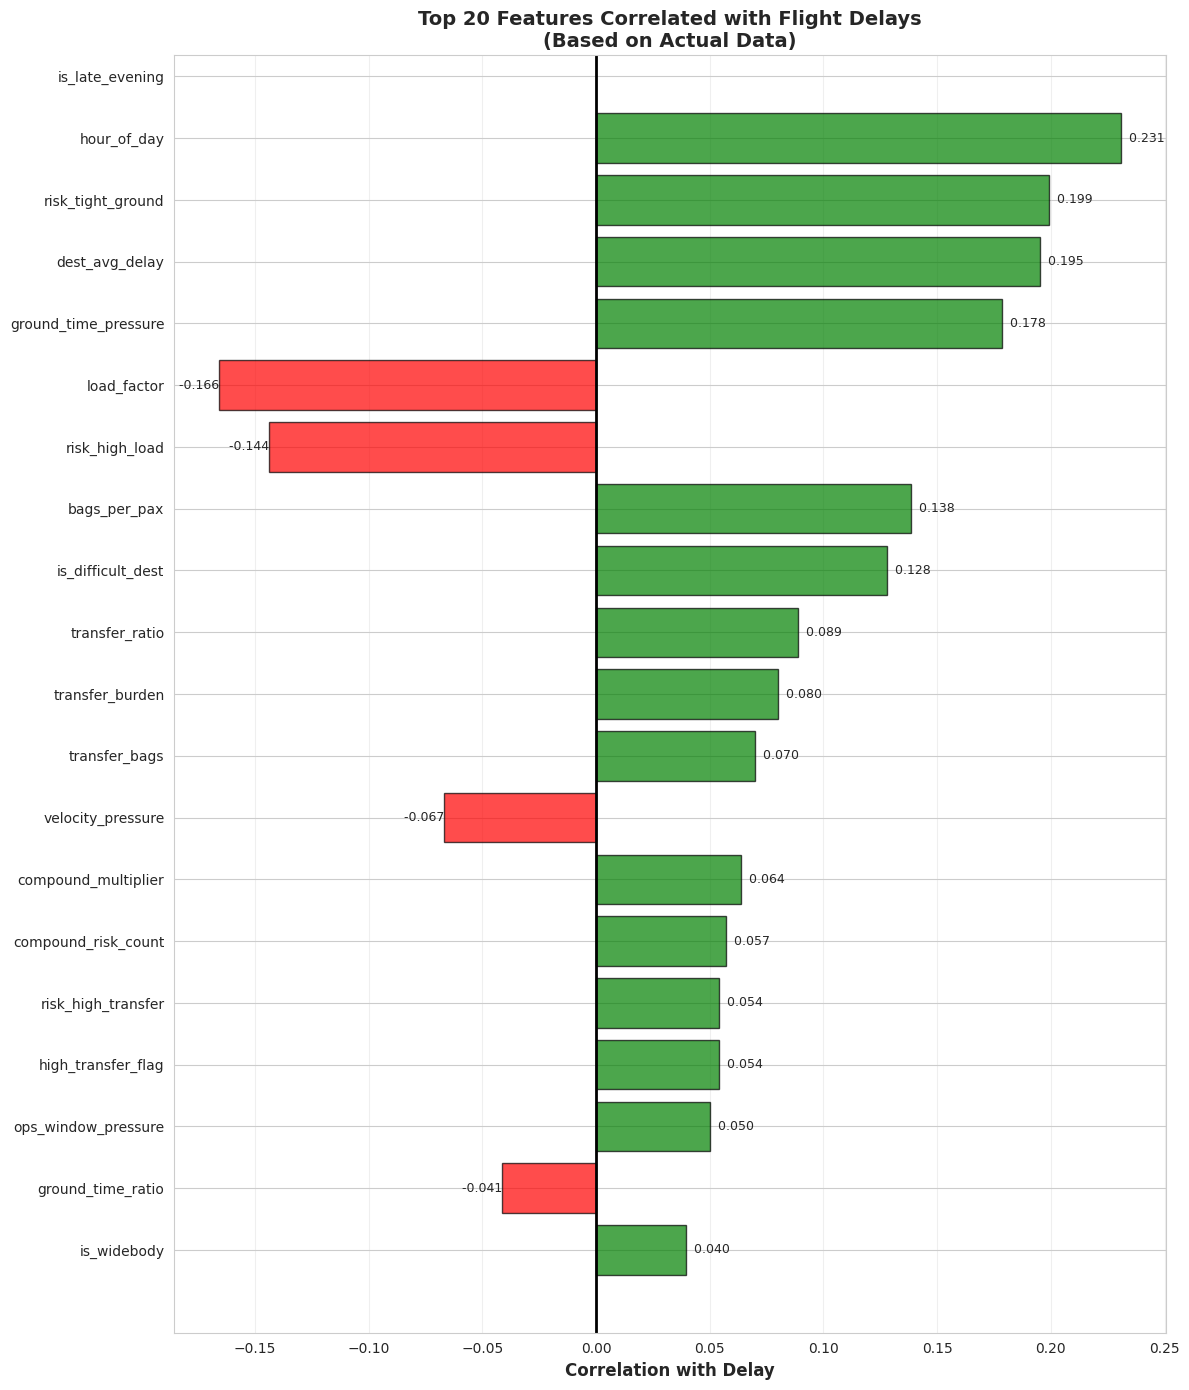

✅ Feature importance chart saved as 'feature_importance.png'


In [ ]:
# Visualize feature correlations
fig, ax = plt.subplots(figsize=(12, 14))

# Get top 20 features by absolute correlation
top_features = correlations.abs().sort_values(ascending=True).tail(20)

# Color by positive/negative
colors_corr = ['red' if correlations[feat] < 0 else 'green' for feat in top_features.index]

ax.barh(range(len(top_features)), [correlations[feat] for feat in top_features.index],
        color=colors_corr, alpha=0.7, edgecolor='black')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features.index, fontsize=10)
ax.set_xlabel('Correlation with Delay', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Features Correlated with Flight Delays\n(Based on Actual Data)',
             fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linewidth=2)
ax.grid(True, alpha=0.3, axis='x')

# Add correlation values on bars
for i, feat in enumerate(top_features.index):
    value = correlations[feat]
    ax.text(value, i, f'  {value:.3f}', va='center',
            ha='left' if value > 0 else 'right', fontsize=9)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Feature importance chart saved as 'feature_importance.png'")

In [ ]:
# ========================================
# PART 11: SAVE MASTER DATASET
# ========================================
import os
print("\n💾 Saving master dataset...")
print("="*60)

# Select columns for final dataset
final_columns = [
    # Identifiers
    'company_id', 'flight_number', 'scheduled_departure_date_local',
    'scheduled_departure_station_code', 'scheduled_arrival_station_code',
    'scheduled_departure_datetime_local', 'scheduled_arrival_datetime_local',

    # Flight basics
    'total_seats', 'fleet_type', 'carrier',

    # Ground time
    'scheduled_ground_time_minutes', 'minimum_turn_minutes',
    'ground_time_ratio', 'ground_time_pressure',

    # Baggage
    'total_bags', 'transfer_bags', 'checked_bags', 'transfer_ratio',
    'baggage_velocity', 'transfer_velocity', 'velocity_pressure',
    'high_transfer_flag', 'transfer_burden',

    # Passengers
    'total_pax', 'load_factor', 'bags_per_pax',
    'basic_economy_ind', 'basic_economy_ratio',

    # Children
    'is_child', 'lap_child_count', 'is_stroller_user',
    'child_complexity', 'child_ratio',

    # Services
    'special_service_count', 'service_intensity',

    # Time
    'hour_of_day', 'day_of_week', 'is_weekend',
    'is_peak_hour', 'is_early_morning', 'is_late_evening',

    # Aircraft
    'aircraft_size_score', 'is_widebody',

    # Destination
    'is_international', 'dest_avg_delay', 'is_difficult_dest',

    # Compound features
    'compound_risk_count', 'compound_multiplier',
    'minutes_per_pax', 'ops_window_pressure',

    # Risk flags
    'risk_tight_ground', 'risk_high_transfer',
    'risk_high_load', 'risk_many_bags',

    # Actual metrics (for validation)
    'delay_minutes', 'actual_departure_datetime_local'
]

# Create final dataset
master_final = master_df[final_columns].copy()

# Save to CSV
master_final.to_csv('master_dataset_for_scoring.csv', index=False)

print(f"✅ Master dataset saved!")
print(f"   File: master_dataset_for_scoring.csv")
print(f"   Total flights: {len(master_final):,}")
print(f"   Total features: {len(final_columns)}")
print(f"   File size: {os.path.getsize('master_dataset_for_scoring.csv') / 1024:.1f} KB")

# Also save a sample for testing
master_final.head(200).to_csv('sample_master_dataset.csv', index=False)
print(f"\n✅ Sample dataset saved (200 flights) for quick testing")

# Save summary statistics
summary_stats = master_final.describe().T
summary_stats.to_csv('feature_summary_statistics.csv')
print(f"✅ Summary statistics saved")

print("\n" + "="*60)


💾 Saving master dataset...
✅ Master dataset saved!
   File: master_dataset_for_scoring.csv
   Total flights: 8,099
   Total features: 56
   File size: 3326.8 KB

✅ Sample dataset saved (200 flights) for quick testing
✅ Summary statistics saved




📊 Creating feature distribution visualizations...


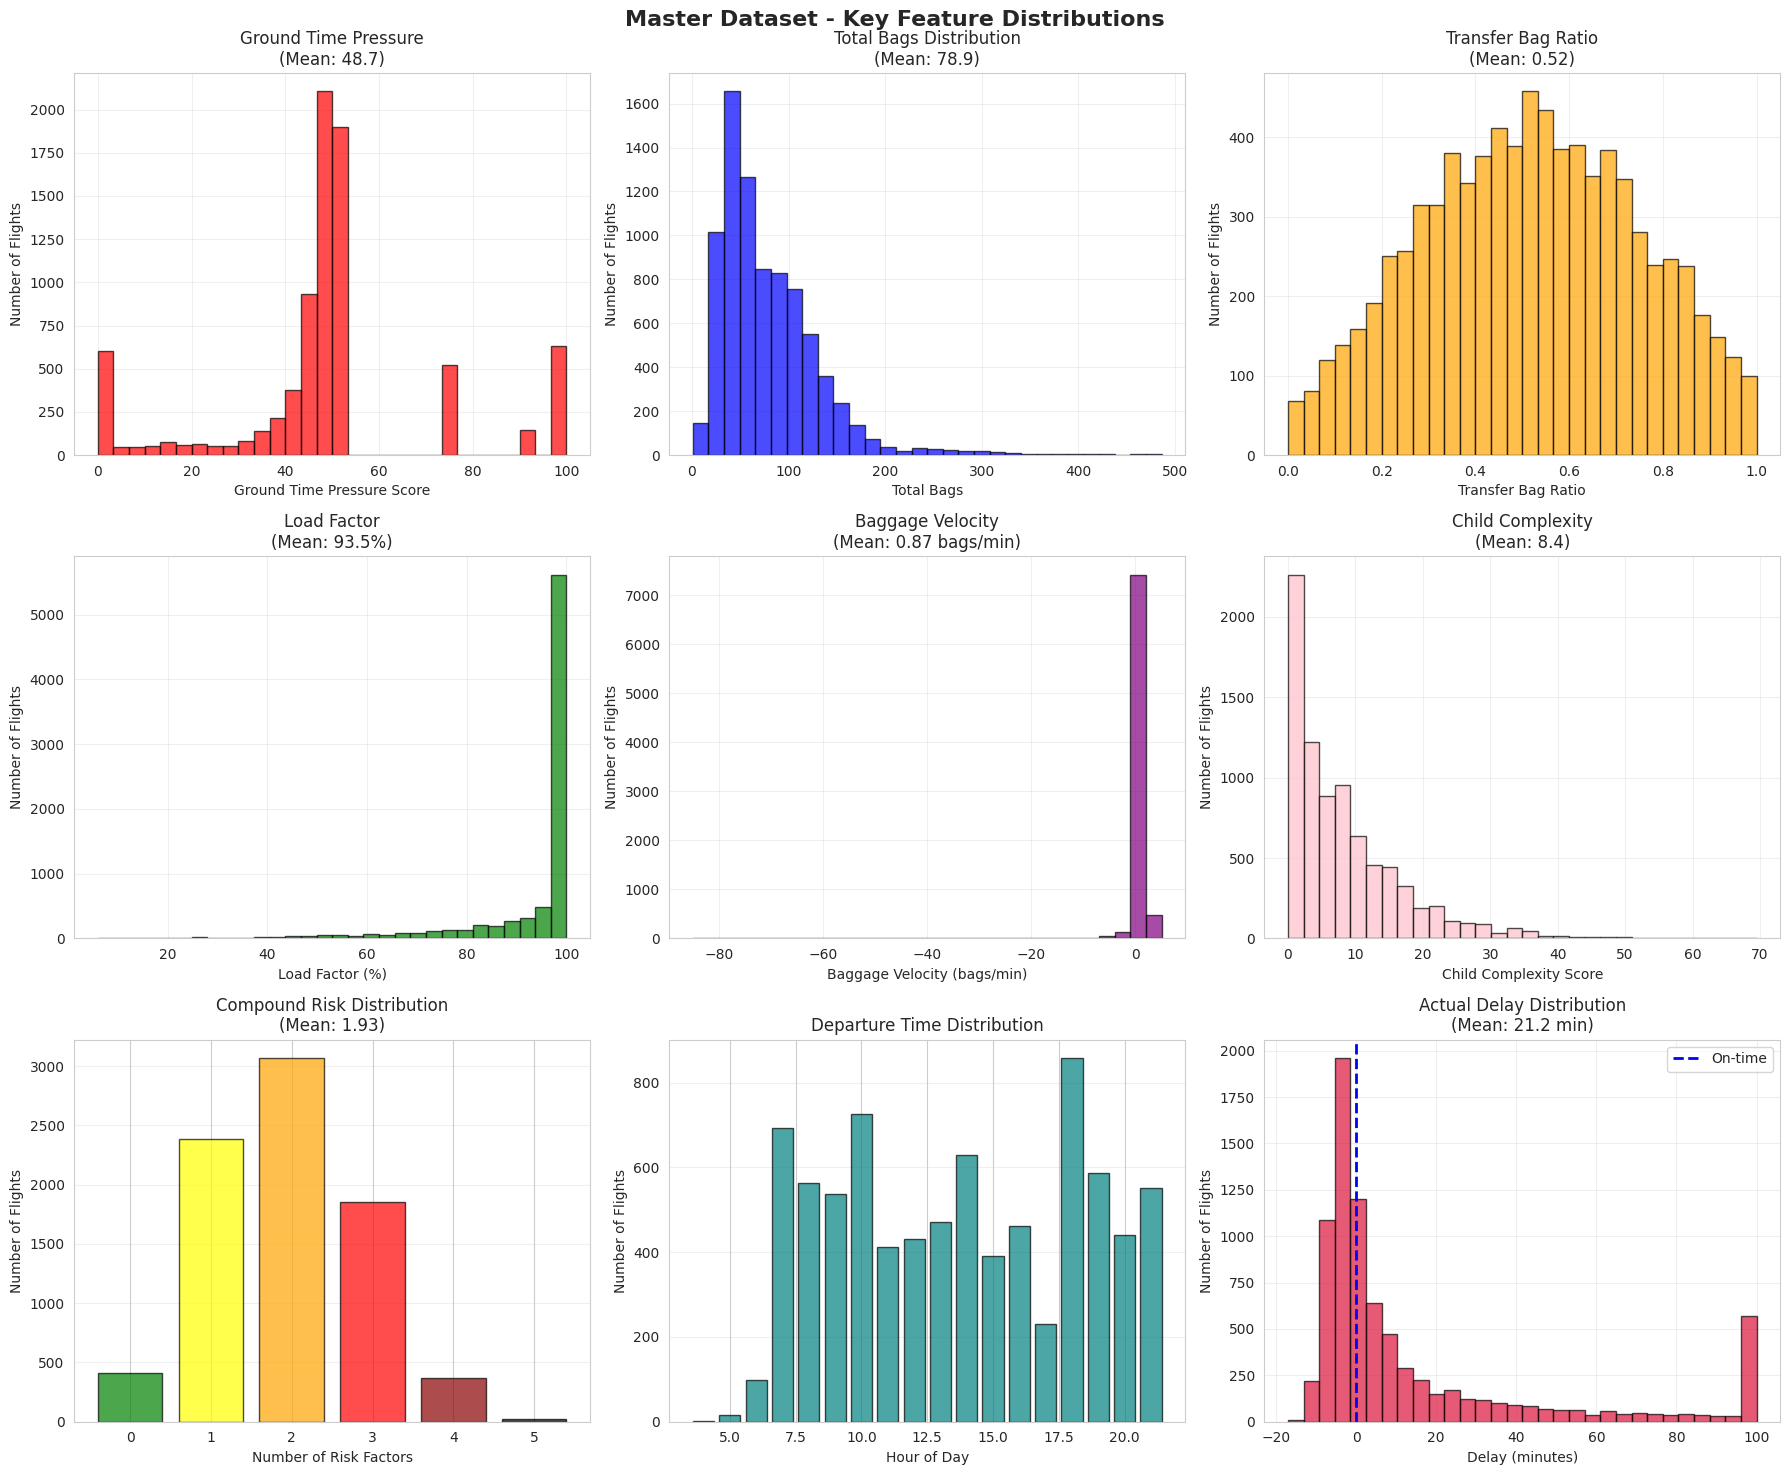

✅ Feature distributions saved as 'master_dataset_distributions.png'


In [ ]:
# ========================================
# PART 13: VISUALIZE FEATURE DISTRIBUTIONS
# ========================================

print("\n📊 Creating feature distribution visualizations...")
print("="*60)

# Create comprehensive visualization
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Master Dataset - Key Feature Distributions', fontsize=16, fontweight='bold')

# 1. Ground Time Pressure
axes[0, 0].hist(master_final['ground_time_pressure'], bins=30,
                edgecolor='black', alpha=0.7, color='red')
axes[0, 0].set_xlabel('Ground Time Pressure Score')
axes[0, 0].set_ylabel('Number of Flights')
axes[0, 0].set_title(f'Ground Time Pressure\n(Mean: {master_final["ground_time_pressure"].mean():.1f})')
axes[0, 0].grid(True, alpha=0.3)

# 2. Total Bags
axes[0, 1].hist(master_final['total_bags'], bins=30,
                edgecolor='black', alpha=0.7, color='blue')
axes[0, 1].set_xlabel('Total Bags')
axes[0, 1].set_ylabel('Number of Flights')
axes[0, 1].set_title(f'Total Bags Distribution\n(Mean: {master_final["total_bags"].mean():.1f})')
axes[0, 1].grid(True, alpha=0.3)

# 3. Transfer Ratio
axes[0, 2].hist(master_final['transfer_ratio'], bins=30,
                edgecolor='black', alpha=0.7, color='orange')
axes[0, 2].set_xlabel('Transfer Bag Ratio')
axes[0, 2].set_ylabel('Number of Flights')
axes[0, 2].set_title(f'Transfer Bag Ratio\n(Mean: {master_final["transfer_ratio"].mean():.2f})')
axes[0, 2].grid(True, alpha=0.3)

# 4. Load Factor
axes[1, 0].hist(master_final['load_factor'] * 100, bins=30,
                edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('Load Factor (%)')
axes[1, 0].set_ylabel('Number of Flights')
axes[1, 0].set_title(f'Load Factor\n(Mean: {master_final["load_factor"].mean():.1%})')
axes[1, 0].grid(True, alpha=0.3)

# 5. Baggage Velocity
axes[1, 1].hist(master_final['baggage_velocity'].clip(upper=5), bins=30,
                edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].set_xlabel('Baggage Velocity (bags/min)')
axes[1, 1].set_ylabel('Number of Flights')
axes[1, 1].set_title(f'Baggage Velocity\n(Mean: {master_final["baggage_velocity"].mean():.2f} bags/min)')
axes[1, 1].grid(True, alpha=0.3)

# 6. Child Complexity
axes[1, 2].hist(master_final['child_complexity'], bins=30,
                edgecolor='black', alpha=0.7, color='pink')
axes[1, 2].set_xlabel('Child Complexity Score')
axes[1, 2].set_ylabel('Number of Flights')
axes[1, 2].set_title(f'Child Complexity\n(Mean: {master_final["child_complexity"].mean():.1f})')
axes[1, 2].grid(True, alpha=0.3)

# 7. Compound Risk Count
risk_counts = master_final['compound_risk_count'].value_counts().sort_index()
axes[2, 0].bar(risk_counts.index, risk_counts.values,
               color=['green', 'yellow', 'orange', 'red', 'darkred', 'black'][:len(risk_counts)],
               alpha=0.7, edgecolor='black')
axes[2, 0].set_xlabel('Number of Risk Factors')
axes[2, 0].set_ylabel('Number of Flights')
axes[2, 0].set_title(f'Compound Risk Distribution\n(Mean: {master_final["compound_risk_count"].mean():.2f})')
axes[2, 0].grid(True, alpha=0.3, axis='y')

# 8. Hour of Day Distribution
hour_counts = master_final['hour_of_day'].value_counts().sort_index()
axes[2, 1].bar(hour_counts.index, hour_counts.values,
               alpha=0.7, edgecolor='black', color='teal')
axes[2, 1].set_xlabel('Hour of Day')
axes[2, 1].set_ylabel('Number of Flights')
axes[2, 1].set_title('Departure Time Distribution')
axes[2, 1].grid(True, alpha=0.3, axis='y')

# 9. Delay Distribution (for validation)
valid_delays = master_final[master_final['delay_minutes'].notna()]['delay_minutes']
axes[2, 2].hist(valid_delays.clip(-20, 100), bins=30,
                edgecolor='black', alpha=0.7, color='crimson')
axes[2, 2].axvline(0, color='blue', linestyle='--', linewidth=2, label='On-time')
axes[2, 2].set_xlabel('Delay (minutes)')
axes[2, 2].set_ylabel('Number of Flights')
axes[2, 2].set_title(f'Actual Delay Distribution\n(Mean: {valid_delays.mean():.1f} min)')
axes[2, 2].legend()
axes[2, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('master_dataset_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Feature distributions saved as 'master_dataset_distributions.png'")

In [ ]:
# ========================================
# PART 14: CREATE SUMMARY REPORT
# ========================================

print("\n📝 Generating summary report...")
print("="*60)

summary_report = f"""
{'='*70}
MASTER DATASET SUMMARY REPORT
{'='*70}

📊 DATASET OVERVIEW
{'='*70}
Total Flights:                {len(master_final):,}
Date Range:                   {master_final['scheduled_departure_date_local'].min()} to {master_final['scheduled_departure_date_local'].max()}
Total Features:               {len(final_columns)}
Flights with Delay Data:      {master_final['delay_minutes'].notna().sum():,} ({(master_final['delay_minutes'].notna().sum()/len(master_final)*100):.1f}%)

🎯 KEY METRICS (Averages)
{'='*70}
Ground Time Pressure:         {master_final['ground_time_pressure'].mean():.2f} / 100
Total Bags per Flight:        {master_final['total_bags'].mean():.1f}
Transfer Bag Ratio:           {master_final['transfer_ratio'].mean():.1%}
Load Factor:                  {master_final['load_factor'].mean():.1%}
Baggage Velocity:             {master_final['baggage_velocity'].mean():.2f} bags/min
Transfer Velocity:            {master_final['transfer_velocity'].mean():.2f} bags/min
Child Complexity:             {master_final['child_complexity'].mean():.2f}
Special Services per Flight:  {master_final['special_service_count'].mean():.2f}
Compound Risk Count:          {master_final['compound_risk_count'].mean():.2f} / 5

⚠️ HIGH-RISK FLIGHT STATISTICS
{'='*70}
Tight Ground Time (<1.2x):    {master_final['risk_tight_ground'].sum():,} ({(master_final['risk_tight_ground'].sum()/len(master_final)*100):.1f}%)
High Transfer Ratio (>70%):   {master_final['risk_high_transfer'].sum():,} ({(master_final['risk_high_transfer'].sum()/len(master_final)*100):.1f}%)
High Load Factor (>90%):      {master_final['risk_high_load'].sum():,} ({(master_final['risk_high_load'].sum()/len(master_final)*100):.1f}%)
Peak Hour Departures:         {master_final['is_peak_hour'].sum():,} ({(master_final['is_peak_hour'].sum()/len(master_final)*100):.1f}%)
Flights with 3+ Risk Factors: {(master_final['compound_risk_count'] >= 3).sum():,} ({((master_final['compound_risk_count'] >= 3).sum()/len(master_final)*100):.1f}%)

🌍 DESTINATION BREAKDOWN
{'='*70}
International Flights:        {master_final['is_international'].sum():,} ({(master_final['is_international'].sum()/len(master_final)*100):.1f}%)
Domestic Flights:             {(master_final['is_international'] == 0).sum():,} ({((master_final['is_international'] == 0).sum()/len(master_final)*100):.1f}%)
Difficult Destinations:       {master_final['is_difficult_dest'].sum():,} ({(master_final['is_difficult_dest'].sum()/len(master_final)*100):.1f}%)

✈️ AIRCRAFT BREAKDOWN
{'='*70}
Wide-body Flights:            {master_final['is_widebody'].sum():,} ({(master_final['is_widebody'].sum()/len(master_final)*100):.1f}%)
Mainline Flights:             {(master_final['carrier'] == 'Mainline').sum():,} ({((master_final['carrier'] == 'Mainline').sum()/len(master_final)*100):.1f}%)
Express Flights:              {(master_final['carrier'] == 'Express').sum():,} ({((master_final['carrier'] == 'Express').sum()/len(master_final)*100):.1f}%)

⏰ TIME DISTRIBUTION
{'='*70}
Early Morning (<6am):         {master_final['is_early_morning'].sum():,} ({(master_final['is_early_morning'].sum()/len(master_final)*100):.1f}%)
Peak Hours (6-9am, 5-8pm):    {master_final['is_peak_hour'].sum():,} ({(master_final['is_peak_hour'].sum()/len(master_final)*100):.1f}%)
Late Evening (>10pm):         {master_final['is_late_evening'].sum():,} ({(master_final['is_late_evening'].sum()/len(master_final)*100):.1f}%)
Weekend Flights:              {master_final['is_weekend'].sum():,} ({(master_final['is_weekend'].sum()/len(master_final)*100):.1f}%)

📈 DELAY STATISTICS (Actual)
{'='*70}
Average Delay:                {master_final['delay_minutes'].mean():.2f} minutes
Median Delay:                 {master_final['delay_minutes'].median():.2f} minutes
Flights Delayed:              {(master_final['delay_minutes'] > 0).sum():,} ({((master_final['delay_minutes'] > 0).sum()/master_final['delay_minutes'].notna().sum()*100):.1f}%)
Max Delay:                    {master_final['delay_minutes'].max():.0f} minutes

🎯 TOP CORRELATED FEATURES WITH DELAY
{'='*70}
"""

if os.path.exists('feature_correlations.csv'):
    corr_data = pd.read_csv('feature_correlations.csv', index_col=0)
    summary_report += "\nTop 5 Positive Correlations:\n"
    for feat, val in corr_data.head(5).iterrows():
        summary_report += f"  • {feat}: {val.values[0]:.4f}\n"

    summary_report += "\nTop 5 Negative Correlations:\n"
    for feat, val in corr_data.tail(5).iterrows():
        summary_report += f"  • {feat}: {val.values[0]:.4f}\n"

summary_report += f"""
{'='*70}
✅ DATA QUALITY STATUS
{'='*70}
Null Values:                  {master_final.isnull().sum().sum()} total
Duplicate Flights:            {master_final.duplicated(subset=['flight_number', 'scheduled_departure_date_local']).sum()}
Data Completeness:            {((1 - master_final.isnull().sum().sum() / (len(master_final) * len(master_final.columns))) * 100):.2f}%

{'='*70}
📁 FILES GENERATED
{'='*70}
✅ master_dataset_for_scoring.csv       (Main dataset)
✅ sample_master_dataset.csv            (200 flight sample)
✅ feature_summary_statistics.csv       (Statistical summary)
✅ feature_correlations.csv             (Correlation analysis)
✅ master_dataset_distributions.png     (Visualizations)
✅ feature_importance.png               (Top features)

{'='*70}
🎯 NEXT STEPS
{'='*70}
1. Build difficulty score using these features
2. Focus on high-correlation features:
   - Ground time pressure
   - Transfer bags & velocity
   - Compound risk factors

3. Apply daily ranking and classification

{'='*70}
Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
{'='*70}
"""


print(summary_report)


with open('master_dataset_summary.txt', 'w') as f:
    f.write(summary_report)

print("\n✅ Summary report saved as 'master_dataset_summary.txt'")


📝 Generating summary report...

MASTER DATASET SUMMARY REPORT

📊 DATASET OVERVIEW
Total Flights:                8,099
Date Range:                   2025-08-01 to 2025-08-15
Total Features:               56
Flights with Delay Data:      8,099 (100.0%)

🎯 KEY METRICS (Averages)
Ground Time Pressure:         48.65 / 100
Total Bags per Flight:        78.9
Transfer Bag Ratio:           51.5%
Load Factor:                  93.5%
Baggage Velocity:             0.87 bags/min
Transfer Velocity:            0.42 bags/min
Child Complexity:             8.39
Special Services per Flight:  0.45
Compound Risk Count:          1.93 / 5

⚠️ HIGH-RISK FLIGHT STATISTICS
Tight Ground Time (<1.2x):    1,300 (16.1%)
High Transfer Ratio (>70%):   1,883 (23.2%)
High Load Factor (>90%):      6,437 (79.5%)
Peak Hour Departures:         4,008 (49.5%)
Flights with 3+ Risk Factors: 2,241 (27.7%)

🌍 DESTINATION BREAKDOWN
International Flights:        747 (9.2%)
Domestic Flights:             7,352 (90.8%)
Difficult Dest